This notebook is for Korean.

I refer to these codes for making this notebook. Special thanks to @iamleonie, @ihelon, @andradaolteanu, @tomwarrens.
* https://www.kaggle.com/iamleonie/intro-to-indoor-location-navigation
* https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
* https://www.kaggle.com/andradaolteanu/indoor-navigation-complete-data-understanding
* https://www.kaggle.com/tomwarrens/indoor-location-and-navigation-start

# **대회 소개**

이 대회는 Microsoft Research에서 주최하는 Indoor Location & Navigation 대회입니다. 대회의 이름에서부터 알 수 있듯이, 실내에서의 사람 위치 및 경로를 예측하는 것을 목적으로 합니다. 스마트폰에서 수집할 수 있는 와이파이 신호, 가속도계, 자기장 센서 등을 이용하여 실내에서의 위치와 동선을 예측합니다. LGBM 등 GBDT 모델이나 RNN 같은 딥러닝을 사용할 수 있습니다. 

대회에 등장하는 장소들은 주로 중국에 실제로 위치한 쇼핑몰, 컨벤션 센터 등 거대한 실내 공간이 있는 장소들입니다. 우리나라로 예를 들자면 코엑스와 비슷하다고 생각하면 됩니다. 

주로 csv 파일로 주어지는 다른 대회들과 달리 이 대회는 txt 파일을 이용해 데이터를 제공합니다. 또한, 이미지 파일 및 json 등의 추가적인 데이터가 많아 훈련에 좋게 데이터를 전처리하는 것에 큰 노력이 필요해 보입니다. 이 notebook에서는 대회의 복잡한 데이터 구조와 각 feature들을 설명하고자 합니다. 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 50
pd.options.display.max_colwidth  = 200
from dataclasses import dataclass

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from tqdm import tqdm

import json
import plotly.graph_objs as go
from PIL import Image, ImageOps
import os
import glob
import math
import json
import cv2
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from math import floor, ceil
mycolors = ["#797D62", "#9B9B7A", "#D9AE94", "#FFCB69", "#D08C60", "#997B66"]
import colorama
from colorama import Fore, Back, Style
import folium
import re
import pyproj
from pyproj import Proj, transform
from shapely.ops import cascaded_union
import warnings # Supress warnings 
warnings.filterwarnings('ignore')
import geopandas as gpd
metadata_path = '/kaggle/input/indoor-location-navigation/metadata/'
train_path = '/kaggle/input/indoor-location-navigation/train/'
test_path = '/kaggle/input/indoor-location-navigation/test/'

test_structure = {test_path: ['path_1.txt','path_2.txt','path_3.txt','...', 'path_n.txt']}

metadata_structure = {metadata_path: 
                               {'site_1': {'floor_1': ['geojson_map.json', 'floor_info.json', 'floor_image.png'],
                                           'floor_2': ['geojson_map.json', 'floor_info.json', 'floor_image.png']},
                                'site_2': {'basement': ['geojson_map.json', 'floor_info.json', 'floor_image.png'],
                                           'floor_1': ['geojson_map.json', 'floor_info.json', 'floor_image.png']},
                               }
                     }

train_structure = {train_path: 
                               {'site_1': {'floor_1': ['path_1.txt', 'path_2.txt'],
                                           'floor_2': ['path_1.txt', 'path_2.txt', 'path_3.txt']},
                                'site_2': {'basement': ['path_1.txt'],
                                           'floor_1': ['path_1.txt', 'path_2.txt']},
                               }
                     }

def pretty(d, indent=0, max_enum = 10):
    for enum, (key, value) in enumerate(d.items()):
        if enum < max_enum:
            if ((len(str(key)) < 5) or (any(x in str(key) for x in ['floor', 'basement']))) and ('site' not in str(key)):
                print('\t'*indent, color_dict['floor'] + str(key)) 
            
            elif ((len(str(key)) > 5)):
                print('\t'*indent, color_dict['site'] + str(key)) 
            
            else:
                print('\t' * indent + str(key))
            if isinstance(value, dict):
                pretty(value, indent+1)
            else:
                if (len(value)>0) & (any(x in str(value) for x in ['.json', '.txt', '.png'])):
                    print("""{0}{1}{2}""".format('\t'*(indent+1), color_dict['path'], str(value)))
                else: 
                    print('\t' * (indent+1) + str(value))
        print(Style.RESET_ALL)
                    
def create_dict(metadata_path, max_enum = 1000, files_enum = None):
    
    metadata_dict = {}
    sites = os.listdir(metadata_path)
    metadata_dict[metadata_path] = sites
    sites_path = list(map(lambda x: os.path.join(metadata_path, x), sites))
    sites_dict = {}
    for sites_enum, site_path in enumerate(sites_path):
        
        if sites_enum<max_enum:
            
            site_floors = os.listdir(site_path)
            floors_path = list(map(lambda x: os.path.join(site_path, x), site_floors)) 
            
            floor_dict = {}
            for floor_enum, floor in enumerate(floors_path): 
                if floor_enum<max_enum:
                    if files_enum:
                        floor_dict[site_floors[floor_enum]] = len(os.listdir(floor)[:files_enum])
                    else:
                        floor_dict[site_floors[floor_enum]] = len(os.listdir(floor))
                        
            sites_dict[sites[sites_enum]] = floor_dict
                    
                    
    return {metadata_path: sites_dict}
                    
# copy from https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            continue
       
        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue
        
    
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)
    
    
    
    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

def visualize_trajectory(trajectory, floor_plan_filename, width_meter, 
                         height_meter, title=None, mode='lines + markers + text', show=False):
    """
    Copied from from https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py

    """
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start 0'
    text_list[-1] = f'End {trajectory.shape[0] - 1}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='lightgrey', width=3, dash='dash'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=800,
        height=  800 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig

def visualize_train_trajectory(path):
    """
    Edited from 
    https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
    """
    _id, floor = path.split("/")[:2]
    
    train_floor_data = read_data_file(f"../input/indoor-location-navigation/train/{path}")
    with open(f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualize_trajectory(
        train_floor_data.waypoint[:, 1:3], 
        f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
        f"Visualization of {path}"
    )

# **파일 구조**

* train - 훈련을 위한 데이터입니다. '각 지역 > 각 층 > 각 시간대의' txt 파일 의 구조로 이루어져 있습니다. 
* test - 예측하기 위한 데이터입니다. train과 구조가 동일하지만 위치 데이터가 포함되어 있지 않습니다.
* metadata - 각 지역과 층에 관련한 데이터입니다. 
    * floor_image.png : 각 층의 평면도
    * floor_info.json : 각 층의 정보가 있는 json 파일
    * geojson_map.json : 지역의 위치를 알려주는 json 파일

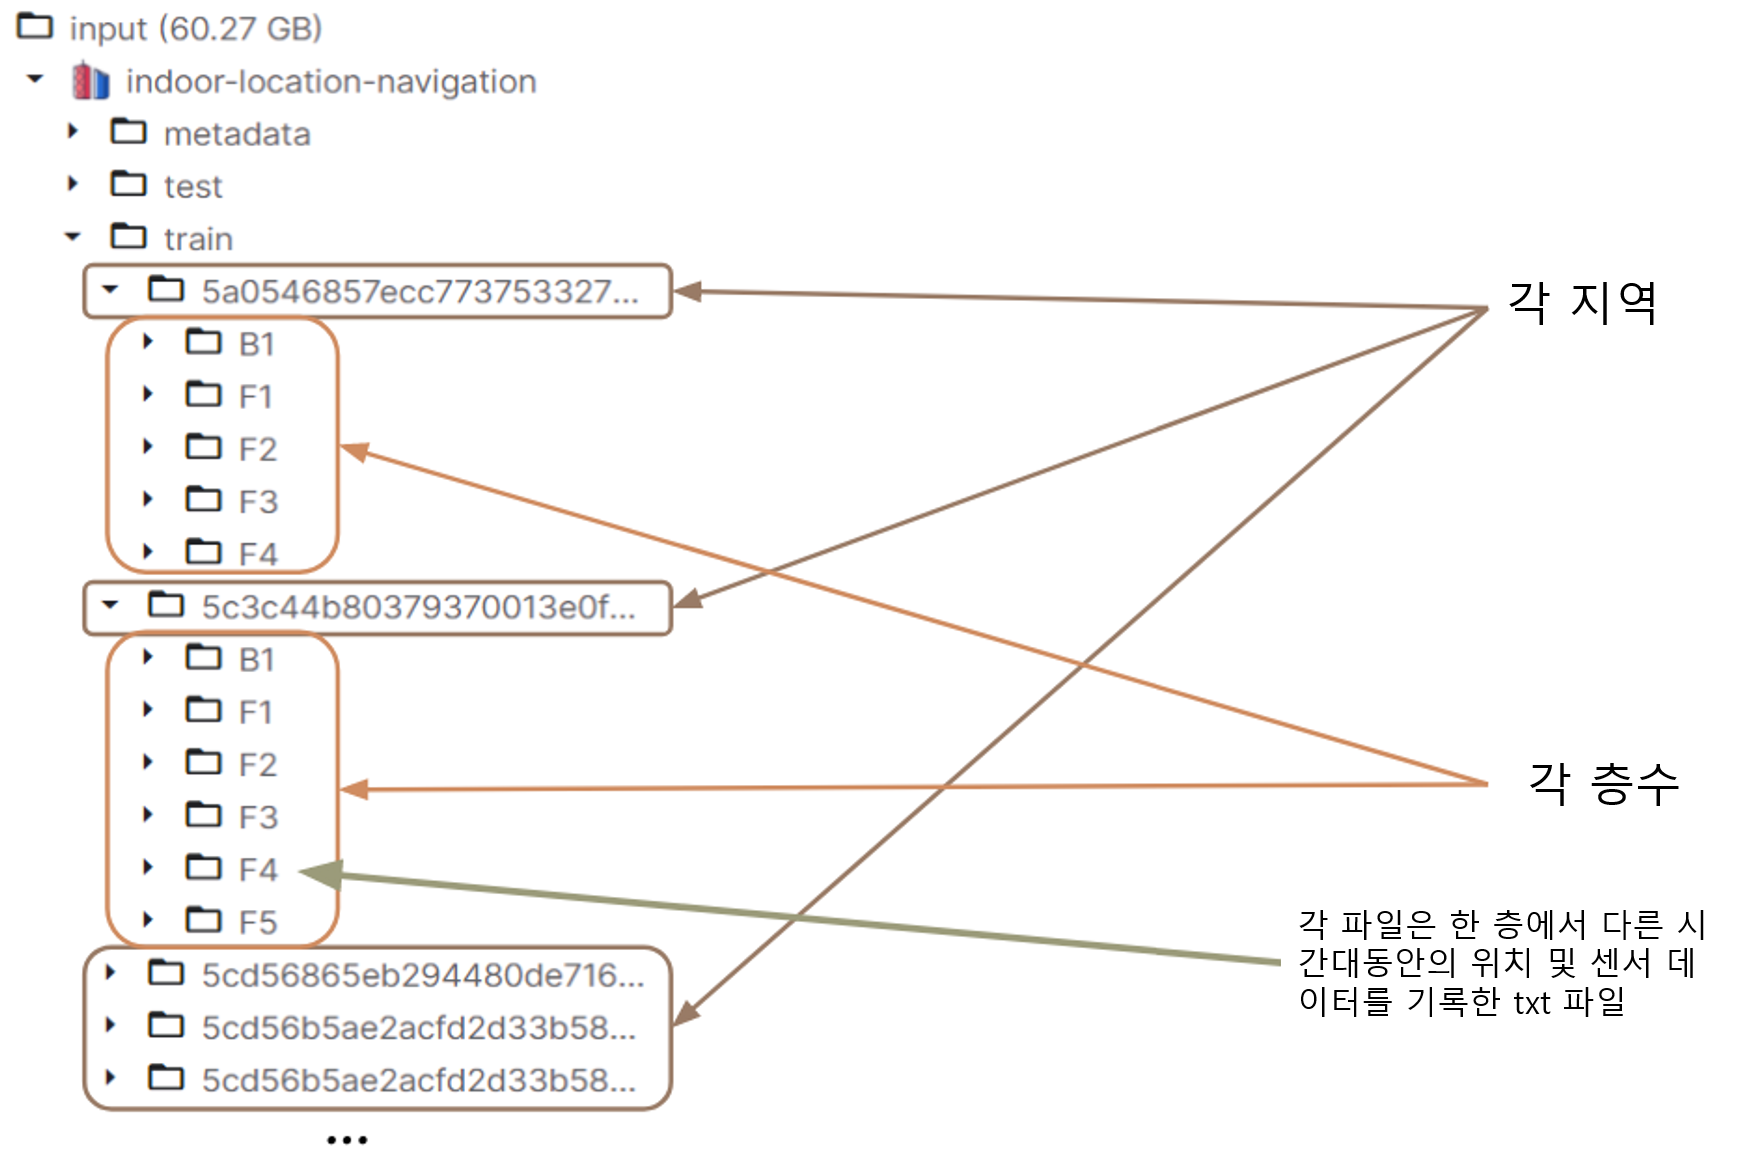

In [ ]:
# 모든 train과 test 파일의 경로를 구합니다.
train_paths = glob.glob('../input/indoor-location-navigation/train/*/*/*')
test_paths = glob.glob('../input/indoor-location-navigation/test/*')
sites = glob.glob('../input/indoor-location-navigation/metadata/*')

print("Train 파일 개수: {:,}".format(len(train_paths)), "\n" +
      "Test 파일 개수: {:,}".format(len(test_paths)), "\n" +
      "총 지역수 (metadata): {:,}".format(len(sites)))

# **Metadata**

* floor_image.png : 각 층의 평면도입니다. 몇 가지를 시각화해보면 다음과 같습니다.


In [ ]:
def plot_all_floors(path_to_building):
    plt.figure(figsize=(16, 10))
    floor_paths = glob.glob(os.path.join(path_to_building, "*/floor_image.png"))
    for ind, floor_path in enumerate(floor_paths):
        w = math.ceil(len(floor_paths) / 2)
        h = math.ceil(len(floor_paths) / w)
        if len(floor_paths) <= 4:
            w = 4
            h = 1
        plt.subplot(h, w, ind + 1)
        image = cv2.imread(floor_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
        plt.title(floor_path.split("/")[-2], fontsize=16)
    plt.show()

In [ ]:
plot_all_floors("../input/indoor-location-navigation/metadata/5a0546857ecc773753327266/")

In [ ]:
plot_all_floors("../input/indoor-location-navigation/metadata/5c3c44b80379370013e0fd2b/")

In [ ]:
plot_all_floors("../input/indoor-location-navigation/metadata/5cd56b6be2acfd2d33b59d1f/")

* floor_info.json : 주로 각 층의 폭과 너비 정보가 포함되어 있습니다.

In [ ]:
with open('../input/indoor-location-navigation/metadata/5a0546857ecc773753327266/B1/floor_info.json', 'r') as f:
    json_data = json.load(f)
print(json.dumps(json_data, indent="\t"))

In [ ]:
with open('../input/indoor-location-navigation/metadata/5c3c44b80379370013e0fd2b/F2/floor_info.json', 'r') as f:
    json_data = json.load(f)
print(json.dumps(json_data, indent="\t"))

* geojson_map.json : 각 지역의 위치 (위도 및 경도), 각 층의 모양이 자세하게 설명 되어있는 json 파일입니다.

In [ ]:
site_name_ = '5cd56c0ce2acfd2d33b6ab27'
site_path = os.path.join(metadata_path, site_name_)
site_structure = {site_path: {'B1': ['geojson_map.json', 'floor_info.json', 'floor_image.png'],
                              'F3': ['geojson_map.json', 'floor_info.json', 'floor_image.png'],
                              'F2': ['geojson_map.json', 'floor_info.json', 'floor_image.png']}}

In [ ]:
floor_info = pd.read_json(os.path.join(site_path, 'B1/floor_info.json'))
floor_image = plt.imread(os.path.join(site_path, 'B1/floor_image.png'))
floor_geo = (gpd.GeoDataFrame.from_features(
                        pd.read_json(os.path.join(site_path, 'B1/geojson_map.json'))['features'])
                     .assign(site_name=site_name_))
fig, axes = plt.subplots(1, 2, figsize = (16, 10))
ax = axes.ravel()
floor_geo['geometry'].plot(ax=ax[0], color = 'red')
ax[0].set_title('Floor {} polygon'.format('B1'))
ax[1].imshow(floor_image)
ax[1].set_title('Floor {} image'.format('B1'))
print("아래와 같이 geojson_map.json 파일만으로 이미지 파일 없이 각 층의 형태를 알 수 있습니다.")
fig.suptitle('Floor Polygon and corresponding Floor Image')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))
ax = axes.ravel()

single_poly_df = (floor_geo.loc[floor_geo.geometry.apply(lambda x: x.geom_type == 'Polygon')]
                 .reset_index(drop = True))

for j in range(len(single_poly_df)):
    single_poly_df.iloc[[j]].plot(ax = ax[j])
    ax[j].set_title("Polygon {}".format(j+1))
    
polygons = []
boundary = gpd.GeoSeries(cascaded_union(single_poly_df.geometry.tolist()))
boundary.plot(color = 'red', ax = ax[4])
ax[4].set_title('Polygon Unions')
floor_geo.iloc[[0]]['geometry'].plot(ax = ax[5], color = 'orange')
ax[5].set_title('MultiPolygon')
print("모든 층을 json 파일을 이용해 표현한 모습입니다.")
plt.suptitle('Floor {} at Site {} Polygons'.format('B1', site_name_ ))

In [ ]:
geo_dfs = []
geo_cols = ["geometry","Vr","category","name","code","floor_num", 'sid',
            "type","id","version","display","point","points","doors", "site_name"]

problematic_sites = []
for site in os.listdir(metadata_path):
    site_path = os.path.join(metadata_path, site)
    for floor in os.listdir(site_path):
        floor_path = os.path.join(site_path, floor)
        try:
            geo_df = (gpd.GeoDataFrame.from_features(
                        pd.read_json(os.path.join(floor_path, 'geojson_map.json'))['features'])
                     .assign(site_name=site))
        except:
            problematic_sites+=[site]
        geo_dfs.append(geo_df)
problematic_sites=list(set(problematic_sites))
full_geo_df = pd.concat(geo_dfs, axis = 0, ignore_index = True)

In [ ]:
print("geojson_map.json 파일의 대략적인 모습입니다. 전체 파일은 매우 길어서 생략했습니다.")
full_geo_df[['geometry', 'point', 'site_name']].sample()

geojson_map.json 파일에 있는 경도와 위도 데이터를 이용해 각 지역을 지도 위에 표시했습니다.

In [ ]:
def get_lat_lon(point, proj = pyproj.Transformer.from_crs(3857, 4326, always_xy=True)):
    try:
        x1, y1 = point[0], point[1]
        lon, lat = proj.transform(x1, y1)
        return lat, lon
    except:
        return np.nan

def get_point(x, i=0):
    try:
        return x[i]
    except:
        return np.nan
    
full_geo_df_sample = full_geo_df.sample(500).reset_index(drop = True)
full_geo_df_sample['lat_lon'] = full_geo_df_sample.point.apply(get_lat_lon)
full_geo_df_sample['lat'] = full_geo_df_sample['lat_lon'].apply(lambda x: get_point(x,0))
full_geo_df_sample['lon'] = full_geo_df_sample['lat_lon'].apply(lambda x: get_point(x,1))

In [ ]:
m = folium.Map(location=[30.7444062,121.1146543], tiles='openstreetmap', zoom_start = 8)

for j in range(len(full_geo_df_sample)):
    try:
        folium.Marker(location=[full_geo_df_sample['lat'][j],
                                full_geo_df_sample['lon'][j]],
                        popup=full_geo_df_sample['site_name'][j],
                        icon = folium.Icon(prefix = 'fa', icon = "map-pin", color = 'blue'),
                        fill_color='#132b5e', num_sides=3, radius=5).add_to(m)
    except:
        continue
m

# **Train/Test**

* 유닉스 시간 : 이 대회에서 사용되는 시간 단위입니다. 1970년 1월 1일을 0으로 설정하며, 정수 형태로 표현이 됩니다. 
datetime 라이브러리를 통하여 보통 사용되는 년-월-일-시-분-초 형태로 변환할 수 있습니다.
유닉스 시간에 대한 자세한 내용은 다음 [링크](https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%89%EC%8A%A4_%EC%8B%9C%EA%B0%84)를 참고해주세요. 

시작 시각과 종료 시각이 유닉스 시간 형태로 각 txt 파일마다 기재되어 있습니다. 

In [ ]:
from datetime import datetime
start_time = 1573713056850 #유닉스 시간의 예시
end_time = 1573713091483 # 정수 형태로 표현이 되어있어 데이터 처리에 용이하지만 직관적이지 않다.

print(datetime.fromtimestamp(start_time/1000.0)) #변환하는 방법은 다음과 같다.
print(datetime.fromtimestamp(end_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0)-datetime.fromtimestamp(start_time/1000.0)) #두 시간대의 차이를 계산

* train/test txt 파일의 형태

각 파일의 feature들과 그 모양을 표시합니다. 각자 다른 지역이나 시간대마다 feature들의 모양이 서로 다릅니다. 각 지역들의 센서, 와이파이 공유기 등의 수가 모두 다르기 때문입니다. 또한, 한 경로에 포함된 위치들의 개수가 차이납니다. 

In [ ]:
train_floor_data = read_data_file("../input/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e15730aa280850006f3d005.txt")
print("acce", train_floor_data.acce.shape)
print("acce_uncali", train_floor_data.acce_uncali.shape)
print("gyro", train_floor_data.gyro.shape)
print("gyro_uncali", train_floor_data.gyro_uncali.shape)
print("magn", train_floor_data.magn.shape)
print("magn_uncali", train_floor_data.magn_uncali.shape)
print("ahrs", train_floor_data.ahrs.shape)
print("wifi", train_floor_data.wifi.shape)
print("ibeacon", train_floor_data.ibeacon.shape)
print("waypoint", train_floor_data.waypoint.shape)
with open("../input/indoor-location-navigation/metadata/5a0546857ecc773753327266/B1/floor_info.json") as f:
    train_floor_info = json.load(f)

In [ ]:
test_floor_data = read_data_file("../input/indoor-location-navigation/test/00ff0c9a71cc37a2ebdd0f05.txt")
print("acce", test_floor_data.acce.shape)
print("acce_uncali", test_floor_data.acce_uncali.shape)
print("gyro", test_floor_data.gyro.shape)
print("gyro_uncali", test_floor_data.gyro_uncali.shape)
print("magn", test_floor_data.magn.shape)
print("magn_uncali", test_floor_data.magn_uncali.shape)
print("ahrs", test_floor_data.ahrs.shape)
print("wifi", test_floor_data.wifi.shape)
print("ibeacon", test_floor_data.ibeacon.shape)
print("waypoint", test_floor_data.waypoint.shape)
print("test 파일에는 waypoint 정보가 없는 것을 볼 수 있습니다.")

* Waypoint : 사람이 이동한 경로의 정보를 담고 있습니다. 시각화하면 아래와 같습니다. 

In [ ]:
# copy from https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py


def save_figure_to_html(fig, filename):
    fig.write_html(filename)


def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines + markers + text', show=False):
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start Point: 0'
    text_list[-1] = f'End Point: {trajectory.shape[0] - 1}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgb(100, 10, 100)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


def visualize_heatmap(position, value, floor_plan_filename, width_meter, height_meter, colorbar_title="colorbar", title=None, show=False):
    fig = go.Figure()

    # add heat map
    fig.add_trace(
        go.Scatter(x=position[:, 0],
                   y=position[:, 1],
                   mode='markers',
                   marker=dict(size=7,
                               color=value,
                               colorbar=dict(title=colorbar_title),
                               colorscale="Rainbow"),
                   text=value,
                   name=title))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig

In [ ]:
def visualize_train_trajectory(path):
    _id, floor = path.split("/")[:2]
    
    train_floor_data = read_data_file(os.path.join("../input/indoor-location-navigation/train/", path))
    with open(f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualize_trajectory(
        train_floor_data.waypoint[:, 1:3], 
        f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
    )

In [ ]:
visualize_train_trajectory("5a0546857ecc773753327266/B1/5e15730aa280850006f3d005.txt")

In [ ]:
visualize_train_trajectory("5cd56b67e2acfd2d33b596bd/F2/5cf5dd5bd1378b0009268ad5.txt")

In [ ]:
visualize_train_trajectory("5cd56b5ae2acfd2d33b5854a/B1/5d07424a1a69370008bc5de5.txt")

In [ ]:
visualize_train_trajectory('5cd56b5ae2acfd2d33b58549/5F/5d06134c4a19c000086c4324.txt')

* Accelerometer (가속도계) : 속도의 변화량인 가속도를 측정합니다. x, y, z 축 방향으로의 가속도 정보가 담겨있습니다. 

In [ ]:
sample_file = read_data_file("../input/indoor-location-navigation/train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")
temp = np.concatenate([sample_file.acce, 
                       sample_file.acce_uncali[:, 1:],
                       sample_file.gyro[:, 1:],
                       sample_file.gyro_uncali[:, 1:],
                       sample_file.magn[:, 1:],
                       sample_file.magn_uncali[:, 1:],
                       sample_file.ahrs[:, 1:],
                      ], axis=1)

imu_df = pd.DataFrame(temp)

imu_df.columns = ['timestamp', 'acce_x','acce_y', 'acce_z','acce_uncali_x','acce_uncali_y', 'acce_uncali_z',
              'gyro_x','gyro_y', 'gyro_z','gyro_uncali_x','gyro_uncali_y', 'gyro_uncali_z',
              'magn_x','magn_y', 'magn_z','magn_uncali_x','magn_uncali_y', 'magn_uncali_z',
              'ahrs_x','ahrs_y', 'ahrs_z']

display(imu_df.head(8).style.set_caption('IMU Data'))

In [ ]:
def plot_imu_signals(col, uncali = True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 9))
    ax[0].set_ylabel(f"{col}_x")
    ax[1].set_ylabel(f"{col}_y")
    ax[2].set_ylabel(f"{col}_z")
    if uncali:
        sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_uncali_x"], ax=ax[0], label = 'uncali', color='orange')
        sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_uncali_y"], ax=ax[1], label = 'uncali', color='orange')
        sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_uncali_z"], ax=ax[2], label = 'uncali', color='orange')
        ax[0].set_ylabel(f"{col}_x \n(calib./uncalib.)")
        ax[1].set_ylabel(f"{col}_y \n(calib./uncalib.)")
        ax[2].set_ylabel(f"{col}_z \n(calib./uncalib.)")
    
    sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_x"], ax=ax[0], label='cali', color='cornflowerblue')
    sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_y"], ax=ax[1], label='cali', color='cornflowerblue')
    sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_z"], ax=ax[2], label='cali', color='cornflowerblue')

    for i in range(3):
        ax[i].set_xlim([start_time, end_time])
    plt.tight_layout()
    plt.show()
    
plot_imu_signals('acce')
    

시간에 따른 가속도의 변화를 보여주는 그래프입니다. 먼저 z축 방향의 가속도계부터 보면, 주로 10 부근을 기준으로 위아래로 진동하는 것을 볼 수 있습니다. 이는 중력가속도 g가 약 9.8이기 때문입니다. 

In [ ]:
imu_df.acce_z.mean() #실제 z축 가속도계의 평균. 중력가속도와 매우 유사하다. 

다음으로 x축과 y축 방향의 가속도계입니다. 위 가속도 값을 이용해 속도 값을 구하고, 그것을 실제 위치와 비교해보겠습니다. 
먼저, 속도와 가속도, 실제 위치간의 이해를 돕기 위한 예시입니다. (고등학생 때 배운 간단한 물리입니다!)

In [ ]:
def calc_from_pos(timestamp, pos):
    df = pd.DataFrame({'timestamp' : timestamp, 'position' : pos})
    df['timestamp_ms'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
    df['timedelta_ms'] = df['timestamp_ms'].diff()
    df['timedelta_s'] = df['timedelta_ms'].apply(lambda x: x.total_seconds()).fillna(0)
    df['velocity'] = (df['position'].diff() / df['timedelta_s']).fillna(0)
    df['acceleration'] = (df['velocity'].diff() / df['timedelta_s']).fillna(0)

    return df[['timestamp', 'timestamp_ms', 'timedelta_s', 'position', 'velocity', 'acceleration']]

def calc_from_acce(timestamp, acce, p_0):
    df = pd.DataFrame({'timestamp' : timestamp, 'acceleration' : acce})
    df['timestamp_ms'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
    df['timedelta_ms'] = df['timestamp_ms'].diff()
    df['timedelta_s'] = df['timedelta_ms'].apply(lambda x: x.total_seconds()).fillna(0)
    df['velocity'] = (df['acceleration']*df['timedelta_s']).cumsum()
    df['position'] = p_0 + (df['velocity']*df['timedelta_s']).cumsum()

    return df[['timestamp', 'timestamp_ms', 'timedelta_s', 'position', 'velocity', 'acceleration']]

a_df = calc_from_acce(pd.Series([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) * 1000 + start_time, 
               pd.Series([0, 0, 1.2, 1.2, 1.2, 0, 0, 0, -1.2, -1.2, -1.2, 0, 0]), -6)
# display(a_df.style.set_caption('Calculated Position and Velocity from Acceleration'))

b_df = calc_from_pos(a_df.timestamp, a_df.position)
# display(b_df.style.set_caption('Calculated Acceleration and Velocity from Position'))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
sns.lineplot(x=a_df.timestamp, y=a_df.position, ax=ax, color='cornflowerblue', marker='o', label='Position ($m$)')
sns.lineplot(x=a_df.timestamp, y=a_df.velocity, ax=ax, color='blue', marker='o', label='Velocity ($m/s$)')
sns.lineplot(x=a_df.timestamp, y=a_df.acceleration, ax=ax, color='seagreen', marker='o', label='Acceleration ($m/s^2$)')

plt.show()

기본적으로 이해하면 좋은 것은 위치, 속도, 가속도간의 관계입니다. 위치의 변화량은 속도이며, 속도의 변화량은 가속도입니다. 위 그래프에서 -5의 위치에서 속도를 높여 이동하다가 5 정도에서 등속으로 운동하며, 10 정도부터 속도를 줄여 15 정도에서 멈추게 됩니다. 속도를 높이는 구간에서는 가속도가 양수이며, 속도를 줄이는 감속 구간에서는 가속도가 음수를 나타냅니다. 

위 그래프에서 실제 위치는 멈추었지만 가속도와 속도는 여전히 0이 아닌 모습을 볼 수 있습니다. (timestamp 67000 즈음) 이것에서 보아 실제 데이터의 가속도계로 예측한 위치는 정확하지 않고 오류가 존재할 것입니다. 

이제 위의 가속도계 데이터와 실제 위치와의 관계를 보도록 하겠습니다. 초록색 resampled data는 가속도계의 시간 간격을 0.2초로 조정하여 나타낸 것입니다. (하늘색은 1초 간격)

In [ ]:
waypoint_df = pd.DataFrame(sample_file.waypoint)
waypoint_df.columns = ['timestamp', 'waypoint_x','waypoint_y']
# Resampled
imu_df_temp = calc_from_acce(imu_df.timestamp, 
                      (-1)*imu_df.acce_x, 
                      waypoint_df.waypoint_x.iloc[0])

imu_df_resampled = imu_df[['timestamp', 'acce_x' ]].copy()
imu_df_resampled.index = imu_df_resampled['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
imu_df_resampled = imu_df_resampled.resample('1S').mean().reset_index(drop=True)
imu_df_resampled.acce_x.iloc[0] = 0
imu_df_resampled.head()

imu_df_temp_resampled = calc_from_acce(imu_df_resampled.timestamp, 
                      (-1)*imu_df_resampled.acce_x, 
                      waypoint_df.waypoint_x.iloc[0])
waypoint_df_temp = calc_from_pos(waypoint_df.timestamp, waypoint_df.waypoint_x)
# display(imu_df_temp_resampled.head(5).style.set_caption('Calculated Position and Velocity from resampled acce_x'))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.position, ax=ax[0], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.position, ax=ax[0], color='cornflowerblue', label='acce_x')
sns.lineplot(x=imu_df_temp_resampled.timestamp, y=imu_df_temp_resampled.position, ax=ax[0], color='green', marker='o', label='resampled acce_x')
ax[0].set_ylabel('Position x \n($m$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.velocity, ax=ax[1], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.velocity, ax=ax[1], color='cornflowerblue', label='acce_x')
sns.lineplot(x=imu_df_temp_resampled.timestamp, y=imu_df_temp_resampled.velocity, ax=ax[1], color='green', marker='o', label='resampled acce_x')

ax[1].set_ylabel('Velocity x \n($m/s$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.acceleration, ax=ax[2], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.acceleration, ax=ax[2], color='cornflowerblue', label='acce_x')
sns.lineplot(x=imu_df_temp_resampled.timestamp, y=imu_df_temp_resampled.acceleration, ax=ax[2], color='green', marker='o', label='resampled acce_x')

ax[2].set_ylabel('Acceleration x \n($m/s^2$)')

plt.show()

실제 위치와 가속도계간의 관계에 오류가 많아 보입니다. 의미있는 위치 예측을 위해서는 가속도계의 데이터를 더 좋은 방법으로 변환해야 할 필요성이 있습니다. 

In [ ]:
!cp -r ../input/indoor-locationnavigation-2021/indoor-location-competition-20-master/* ./

* Magnetic Strength (자기장 세기)

건물 안에서는 모두 고유의 자기장을 가집니다. 자기장 데이터는  3차원 공간에 형성된 자기장을 x, y, z 벡터로 표현할 수 있습니다. 각 사용자가 지닌 스마트폰이 고유한 자기장 안에서 운동하며 자기적 파동을 센서로 감지합니다. 건물의 각 위치나 운동량 등에 따라서 자기장의 세기는 쉽게 바뀔 수 있습니다. 

아래의 지도는 경로에 따른 자기장의 세기 변화를 보여주고 있습니다. 건물의 왼쪽 부근에서는 자기장의 세기가 약한 반면, 오른쪽 아래 부근에서는 상대적으로 자기장의 세기가 강한 것을 볼 수 있습니다. 

In [ ]:
# GitHub functions
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
# GitHub functions
from visualize_f import visualize_trajectory, visualize_heatmap
base = '../input/indoor-location-navigation'
site_path = f"{base}/metadata/{site}/*/floor_image.png"
path = f'{base}/train/5cd56b5ae2acfd2d33b58549/5F/5d06134c4a19c000086c4324.txt'

# Read in a sample
example = read_data_file(path)

# ~~~~~~~~~

# Returns timestamp, x, y values
trajectory = example.waypoint
# Removes timestamp (we only need the coordinates)
trajectory = trajectory[:, 1:3]

# Prepare floor_plan coresponding with our example
site = path.split("/")[4]
floorNo = path.split("/")[5]
floor_plan_filename = f'{base}/metadata/{site}/{floorNo}/floor_image.png'

# Prepare width_meter & height_meter
### (taken from the .json file)
json_plan_filename = f'{base}/metadata/{site}/{floorNo}/floor_info.json'
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

# Extracting the magnetic strength
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position([path])
magnetic_strength = extract_magnetic_strength(mwi_datas)

heat_positions = np.array(list(magnetic_strength.keys()))
heat_values = np.array(list(magnetic_strength.values()))

# Visualize the heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  floor_plan_filename,
                  width_meter, 
                  height_meter, 
                  colorbar_title='mu tesla', 
                  title='Magnetic Strength',
                  g_size=755,
                  colorscale='temps')

* Wifi
와이파이는 가장 중요한 feature중에 하나입니다. 와이파이만 이용하더라도 높은 정확도로 사용자의 위치를 예측할 수 있습니다. 
와이파이는 한 공유기 당 두개의 아이디를 가지고 있습니다. SSID는 보통 보여지는 와이파이의 이름으로, 관리자가 원하는 것으로 변경할 수 있습니다. BSSID는 와이파이 공유기의 고유한 ID로 변경할 수 없는 것이 특징입니다. 

이 대회의 와이파이 데이터는 와이파이 공유기로부터 오는 신호의 세기를 각각 측정하여 경로마다 기록한 것입니다. 이 정보를 통해 사용자의 위치를 예측할 수 있습니다. 아래 지도는 경로 주변의 와이파이 공유기 위치를 표시한 것입니다. 

In [ ]:
# GitHub Libraries
from main import extract_wifi_rssi, extract_wifi_count

# Get WiFi data
wifi_rssi = extract_wifi_rssi(mwi_datas)
print(f'This floor has {len(wifi_rssi.keys())} wifi aps (access points).')

wifi_counts = extract_wifi_count(mwi_datas)
heat_positions = np.array(list(wifi_counts.keys()))
heat_values = np.array(list(wifi_counts.values()))
# filter out positions that no wifi detected
mask = heat_values != 0
heat_positions = heat_positions[mask]
heat_values = heat_values[mask]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  floor_plan_filename, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='count', 
                  title=f'WiFi Count',
                  g_size=755,
                  colorscale='temps')

* Blutooth iBeacon : 블루투스를 기반으로 작동하는 비콘은 와이파이와 비슷한 원리로 사용자의 위치를 추적할 수 있습니다. 경우에 따라서 비콘이 단 하나도 없는 지역이 있어 주의를 요합니다. 아래의 예시는 3개의 비콘이 있으며 각 경로에서 측정된 세기를 표시한 것입니다. 

비콘의 세기 단위는 dBm (데시벨 밀리와트)로, 모두 음수이며 0에 가까울수록 더 강한 세기입니다. 

In [ ]:
from main import extract_ibeacon_rssi

# Getting the iBeacon data
ibeacon_rssi = extract_ibeacon_rssi(mwi_datas)
print(f'This floor has {len(ibeacon_rssi.keys())} ibeacons.')
ibeacon_ummids = list(ibeacon_rssi.keys())
target_ibeacon = ibeacon_ummids[0]
heat_positions = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
heat_values = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:, 0]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  floor_plan_filename, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='dBm', 
                  title='iBeacon RSSE',
                  g_size=755,
                  colorscale='temps')

계속해서 추가 예정입니다.... 

**도움이 되었다면 업보트 (+upvote) 한 번 씩 부탁드립니다:)**